# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.model_selection as skms

# DATA IMPORTS

In [2]:
# Read the data
df = pd.read_csv('finaldf.csv')
n = len(df)


df_test = pd.read_csv('finaltest.csv')
# test can't have nans in order to be predicted
df_test['weight'] = df_test['weight'].fillna(df_test['weight'].mean())
df_test['late_order'] = True

m = len(df_test)
df_def = pd.concat([df, df_test])


# ANALISIS

In [4]:


def get_X_y(df, target):

    X = df.drop(['order_id', "logistic_hub", 'dist_origin_hub',
                "origin_port_coord", "logistic_hub_coord", "customer_coord", "dist_hub_customer", 
                'material_handling'], axis=1).dropna()
    if target:
        y = X['late_order']
        X = X.drop(['late_order'], axis=1)
    X['total_weight'] = X['weight']*X['units']
    X = X.drop(["units", "weight"], axis=1)

    return X if not target else (X, y)

X, y = get_X_y(df, True)
y = y.head(n)

X_enc = pd.get_dummies(X, columns= ["3pl", "origin_port", "customs_procedures", "customer"])
X_ori_enc = X_enc.head(n) 
X_test_enc = X_enc.tail(m)

X_train_enc, X_val_enc, y_train, y_val = skms.train_test_split(X_ori_enc, y, test_size=0.2)




In [8]:
from sklearn.tree import DecisionTreeClassifier
xval = [i for i in range(2, 30)]
rc = np.array([None for _ in range(2, 30)])

for i in range(2, 30):
    modelt = DecisionTreeClassifier(criterion="entropy", max_depth=i)
    modelt.fit(X_train_enc, y_train)
    y_pred = np.array(modelt.predict_proba(X_val_enc)) 
    rc[i-2] = sk.metrics.roc_auc_score(y_val, y_pred.T[1])

print(rc)

[0.6800686470419398 0.7026140970064323 0.7139851606482626
 0.7285377576772524 0.7489803134032665 0.759283362544257
 0.7661042545732304 0.7724657387287047 0.7716168167052636
 0.7674584540396726 0.7580599823514788 0.7466755719573952
 0.7363658652664667 0.727419742971727 0.7150799319583626
 0.7029420525587295 0.6911030296262449 0.6761778788459274
 0.6679817912738448 0.6594808913123636 0.6536131578593083
 0.6467300530835682 0.6432456486527925 0.6402776210985122
 0.6375412836676311 0.634936667603155 0.6372139136843058
 0.6359096089146261]


[Text(0.5, 0.8333333333333334, 'total_weight <= 1066846.0\nentropy = 0.79\nsamples = 91326\nvalue = [69657, 21669]'),
 Text(0.25, 0.5, 'origin_port_Rotterdam <= 0.5\nentropy = 0.727\nsamples = 85600\nvalue = [68242, 17358]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.873\nsamples = 36646\nvalue = [25908, 10738]'),
 Text(0.375, 0.16666666666666666, 'entropy = 0.572\nsamples = 48954\nvalue = [42334, 6620]'),
 Text(0.75, 0.5, 'total_weight <= 1179454.0\nentropy = 0.807\nsamples = 5726\nvalue = [1415, 4311]'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.982\nsamples = 2574\nvalue = [1085, 1489]'),
 Text(0.875, 0.16666666666666666, 'entropy = 0.484\nsamples = 3152\nvalue = [330, 2822]')]

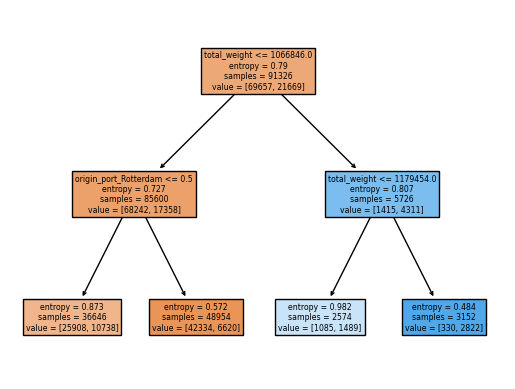

In [9]:
from sklearn.tree import plot_tree
dummodel = DecisionTreeClassifier(criterion="entropy", max_depth=2)
dummodel.fit(X_train_enc, y_train)
plot_tree(dummodel, filled=True, feature_names=X_train_enc.columns)

In [11]:
defmodel = DecisionTreeClassifier(criterion="entropy", max_depth=8)
defmodel.fit(X_train_enc, y_train)
y_pred = defmodel.predict_proba(X_val_enc)

scr = sk.metrics.roc_auc_score(y_val, y_pred.T[1])
print(scr)

0.7659141926008307


In [12]:
y_def = defmodel.predict_proba(X_test_enc)

print(y_def.T[1])


[0.2091203  0.23086243 0.08314789 ... 0.08314789 0.2091203  0.09150189]


In [59]:
submission = pd.DataFrame({"order_id": df_test.order_id, "late_order": y_def.T[1]})
submission.to_csv("submission_kaggle_def2.csv", index=False)